# Design and Implementation of AI Secuirty Scheme for Connected Vehicles
##CSE616 Neural Networks Project
## By Mohamed Saied and Ahmed Gamal
## Under Supervision of Prof.Dr Hazem Abbas
## Ain Shams University


In [ ]:
import numpy as np
import pandas as pd
import random

from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, average_precision_score

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split


In [67]:
!git clone https://github.com/Mohamedsaied8/Connected_Vehicles.git

Cloning into 'Connected_Vehicles'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 3), reused 24 (delta 3), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [68]:
dataset = pd.read_csv("Connected_Vehicles/Main_data_shuffled.csv")

In [69]:
dataset.attacktype.unique()

array([5, 1, 0, 3, 2, 4])

In [70]:
X = dataset.iloc[:,:4].values
y = dataset.iloc[:,4:5].values
X

array([[-3.3626e+00,  2.9137e+01,  2.9330e+01,  0.0000e+00],
       [ 1.0013e+01,  6.2102e-01,  1.0033e+01,  0.0000e+00],
       [ 2.8339e-01,  1.8390e-02,  2.8399e-01,  2.1720e+02],
       ...,
       [ 1.1994e-01, -1.1851e-02,  1.2053e-01,  3.6423e+02],
       [ 2.7600e-01, -1.9197e-01,  3.3619e-01,  6.9873e+01],
       [ 7.5449e-02, -8.5621e-03,  7.5933e-02,  2.8540e+02]])

In [ ]:
#Normalizing data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[-2.91097706e-02,  2.62138960e-01,  1.07145256e-01,
        -4.94288635e-01],
       [ 8.22958841e-02,  5.68466066e-03, -1.10870076e-02,
        -4.94288635e-01],
       [ 1.25775707e-03,  2.64995815e-04, -7.08189621e-02,
        -8.91221354e-02],
       ...,
       [-1.03621431e-04, -6.97219970e-06, -7.18204776e-02,
         1.85148723e-01],
       [ 1.19620560e-03, -1.62684611e-03, -7.04991339e-02,
        -3.63947020e-01],
       [-4.74187909e-04,  2.26060419e-05, -7.20937224e-02,
         3.80986532e-02]])

In [ ]:
lb = LabelBinarizer()
y = lb.fit_transform(y)

In [ ]:
inputs = torch.from_numpy(X).type(torch.float)
targets = torch.from_numpy(y).type(torch.long)
dataset = TensorDataset(inputs, targets)
dataset[0][0].unsqueeze(dim=0)
print(dataset[0][0].shape)
#print(*dataset)


torch.Size([4])


In [ ]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 6)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(4, 6)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(4, 6)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.torch.relu(self.fc1(x))
        # add hidden layer, with relu activation functio
        return x

    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calcuate loss
        loss = F.l1_loss(out, targets)
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        #batch_acc = [z['val_acc'] for z in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        #epoch_acc = torch_stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 100th epoch
        if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch + 1, result['val_loss']))

In [ ]:
train_x, val_x = random_split(dataset, [105000, 320])
train_loader = DataLoader(train_x, batch_size=32, shuffle=True)

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def backward(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history


In [ ]:
model = MLP()
result = evaluate(model, train_loader)
print(result)

{'val_loss': 0.3326951563358307}


In [ ]:
epochs = 1000
lr = 1e-2
history1 = backward(epochs, lr, model, train_loader, val_x)


Epoch [10], val_loss: 0.0780
Epoch [20], val_loss: 0.0757
Epoch [30], val_loss: 0.0743
Epoch [40], val_loss: 0.0732
Epoch [50], val_loss: 0.0723
Epoch [60], val_loss: 0.0716
Epoch [70], val_loss: 0.0710
Epoch [80], val_loss: 0.0707
Epoch [90], val_loss: 0.0706
Epoch [100], val_loss: 0.0704


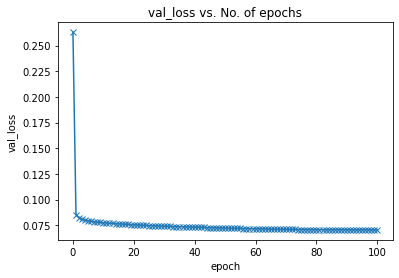

In [ ]:
plt.title('val_loss vs. No. of epochs');
loss_mat = [res['val_loss'] for res in [result] + history1]
plt.plot(loss_mat, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
val_loss = loss_mat[-1]
plt.show()

In [ ]:
epochs = 1000
lr = 1e-3
history2 = backward(epochs, lr, model, train_loader, val_x)

Epoch [10], val_loss: 0.0704
Epoch [20], val_loss: 0.0704
Epoch [30], val_loss: 0.0704
Epoch [40], val_loss: 0.0704
Epoch [50], val_loss: 0.0704
Epoch [60], val_loss: 0.0704
Epoch [70], val_loss: 0.0703
Epoch [80], val_loss: 0.0703
Epoch [90], val_loss: 0.0703
Epoch [100], val_loss: 0.0703
Epoch [110], val_loss: 0.0703
Epoch [120], val_loss: 0.0703
Epoch [130], val_loss: 0.0703
Epoch [140], val_loss: 0.0703
Epoch [150], val_loss: 0.0703
Epoch [160], val_loss: 0.0702
Epoch [170], val_loss: 0.0702
Epoch [180], val_loss: 0.0702
Epoch [190], val_loss: 0.0702
Epoch [200], val_loss: 0.0702
Epoch [210], val_loss: 0.0702
Epoch [220], val_loss: 0.0702
Epoch [230], val_loss: 0.0702
Epoch [240], val_loss: 0.0702
Epoch [250], val_loss: 0.0702
Epoch [260], val_loss: 0.0701
Epoch [270], val_loss: 0.0701
Epoch [280], val_loss: 0.0701
Epoch [290], val_loss: 0.0701
Epoch [300], val_loss: 0.0701
Epoch [310], val_loss: 0.0701
Epoch [320], val_loss: 0.0701
Epoch [330], val_loss: 0.0701
Epoch [340], val_lo

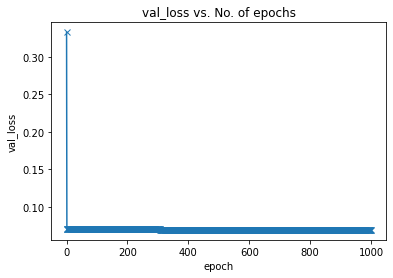

In [ ]:
plt.title('val_loss vs. No. of epochs');
loss_mat = [res['val_loss'] for res in [result] + history2]
plt.plot(loss_mat, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
val_loss = loss_mat[-1]
plt.show()